# Machine Learning Overview
### DSS General Membership Mini-Lecture
Monday, November 4, 2019

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import folium
from geopy.geocoders import Nominatim
import time
%matplotlib inline

### Acknowledgement

This notebook was created by Alan Cha and Zachary Chao in Spring 2019. Mofication made in Fall 2019 by Yuyang Zhong.

### Context

Imaging you were heading up a team with a project to solve: Given this data, solve how we can best predict the fares on future taxi rides in the bay area and San Francisco.

Suppose you had a large database of information. We can assume that our csv file is a random sample of that data so we can work with it locally. This notebook is a sample of how one might go about creating a baseline solution to inform their project. You might not be an expert in the taxi industry, but with some analysis with machine learning, you have the power to make an impact.  This is what I would do in the first two hours of to familiarize myself with the problem and how to move forward with a complicated project.

---
# Part 1: Inital Exploration and Preprocessing 

The first part of the notebook is to get us familiar with our dataset. Before starting a project, its good to have a high level view of whats going on, so we can better inform our more nuanced decisions.

**We will:** 
1. Read in our data 
1. Preproccess some columns 
1. Explore and visualize our data
1. Check for outliers


## Reading in the Data

In [2]:
# dropping irrelevant id column thats a repeat of the index
trips = pd.read_csv('Taxi_Train.csv').drop(['id'],axis=1) 

In [3]:
trips.memory_usage(deep=True).sum() * 1e-6

8.452511

In [4]:
print(trips.shape)
trips.head()

(41898, 10)


,start_time,end_time,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz
0,9/1/12 0:11,9/1/12 0:20,13.20,1.0,-122.413540,37.802683,-122.421277,37.785395,38.0,30.0
1,9/1/12 0:23,9/1/12 0:31,10.65,1.0,-122.419700,37.786090,-122.435217,37.762177,30.0,94.0
2,9/1/12 0:45,9/1/12 0:49,9.00,1.0,-122.415120,37.774672,-122.407657,37.782615,10.0,11.0
3,9/1/12 0:41,9/1/12 0:54,13.95,2.0,-122.419392,37.806622,-122.415393,37.778115,40.0,10.0
4,9/1/12 1:09,9/1/12 1:13,7.35,1.0,-122.429722,37.797790,-122.418060,37.789032,45.0,32.0


**Initial Thoughts**

1. We can't really work with these times that well 
2. What the heck is a TAZ
3. we have a good sized dataset

But they aren't currently useful as they are, so first we will do some preprocessing to turn our data into a usuable form.

In [6]:
# Reformatting time stamps to pandas datetime object
trips['start_time'] = pd.to_datetime(trips['start_time'])
trips['end_time'] = pd.to_datetime(trips['end_time'])

In [18]:
# NOTE: we are using datetime modules for the built in "weekday" function

def get_hour(t):
    return t.hour

def get_weekday(t): # 0 = Monday - 6= Sunday
    return t.date().weekday()

In [19]:
# testing our function on this series.   Note: .map is applying the function to all elements in this column. 
trips['start_time'].map(get_hour)

0         0.0
1         0.0
2         0.0
3         0.0
4         1.0
         ... 
41893     8.0
41894     9.0
41895    10.0
41896    11.0
41897     NaN
Name: start_time, Length: 41898, dtype: float64

Noticed that the last row has an `NaN` value... are there more? Can we clean it up more?

In [24]:
# checking for NaN
trips.isna().sum()

start_time    1
end_time      1
fare          1
number_pax    1
start_lng     1
start_lat     1
end_lng       1
end_lat       1
start_taz     1
end_taz       1
dtype: int64

In [29]:
trips[trips.isna().any(axis=1)]

,start_time,end_time,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz
41897,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
nan_index = trips[trips.isna().any(axis=1)].index
trips = trips.drop(nan_index,axis=0)

In [32]:
trips.isna().sum()

start_time    0
end_time      0
fare          0
number_pax    0
start_lng     0
start_lat     0
end_lng       0
end_lat       0
start_taz     0
end_taz       0
dtype: int64

Great, no more `NaN`!

In [34]:
trips['start_time'].map(get_hour)

0         0
1         0
2         0
3         0
4         1
         ..
41892    19
41893     8
41894     9
41895    10
41896    11
Name: start_time, Length: 41897, dtype: int64

In [35]:
trips['hour_start'] = trips['start_time'].map(get_hour)
trips['weekday'] = trips['start_time'].map(get_weekday)
trips.head()

,start_time,end_time,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz,hour_start,weekday
0,2012-09-01 00:11:00,2012-09-01 00:20:00,13.20,1.0,-122.413540,37.802683,-122.421277,37.785395,38.0,30.0,0,5
1,2012-09-01 00:23:00,2012-09-01 00:31:00,10.65,1.0,-122.419700,37.786090,-122.435217,37.762177,30.0,94.0,0,5
2,2012-09-01 00:45:00,2012-09-01 00:49:00,9.00,1.0,-122.415120,37.774672,-122.407657,37.782615,10.0,11.0,0,5
3,2012-09-01 00:41:00,2012-09-01 00:54:00,13.95,2.0,-122.419392,37.806622,-122.415393,37.778115,40.0,10.0,0,5
4,2012-09-01 01:09:00,2012-09-01 01:13:00,7.35,1.0,-122.429722,37.797790,-122.418060,37.789032,45.0,32.0,1,5


## EDA

Lets just do some quick exploration and visualizations

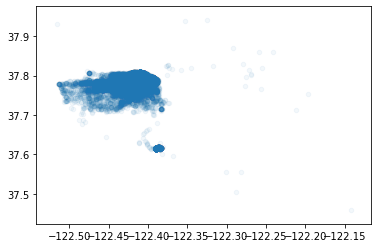

In [38]:
plt.scatter(trips['start_lng'], trips['start_lat'],s=20,alpha=.05);

What do you think the little dot cluster is below?

In [44]:
start_lat = trips['start_lat'][0]
start_lon = trips['start_lng'][0]
map = folium.Map(location=[start_lat, start_lon], zoom_start=11)

end_lat = trips['end_lat'][0]
end_long = trips['end_lng'][0]

circular_marker = folium.CircleMarker(location=[start_lat, start_lon],
                            radius = 3,
                            popup="My marker",
                            fill_color='blue',
                            color='blue',
                            fill_opacity=0.7)
marker_end = folium.CircleMarker(location=[end_lat, end_long],
                            radius = 3,
                            popup="My marker",
                            fill_color='dblue',
                            color='blue',
                            fill_opacity=0.7)

map.add_child(circular_marker)
map.add_child(marker_end)

**Hypothesis:** Focus on those that were going to location of interest. What about SFO?

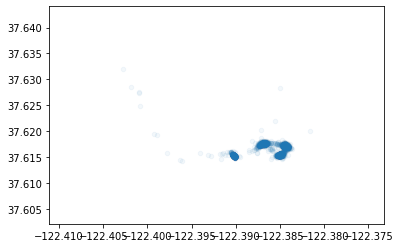

In [46]:
# plotting where the start 
plt.scatter(trips[trips['start_taz'] == 239]['start_lng'],
            trips[trips['start_taz'] == 239]['start_lat'], 
            s=20, alpha=.05);

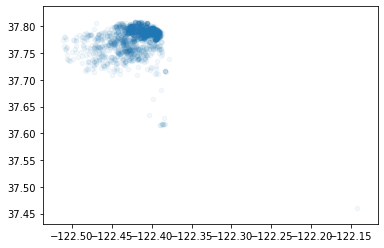

In [47]:
# plotting where they end
plt.scatter(trips[trips['end_taz'] == 239]['start_lng'],
            trips[trips['end_taz'] == 239]['start_lat'], 
            s=20, alpha=.05);

Looks like we have a cluster of trips that go to SFO, the distance is greater and it is plausibly they get taxed or it cost more to go there

**Discussion**

How should we encode the importance of our SFO observation into our data?

In [48]:
trips['SFO'] = ((trips['start_taz'] == 239) | (trips['end_taz'] == 239)).astype(int)
trips.head()

,start_time,end_time,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz,hour_start,weekday,SFO
0,2012-09-01 00:11:00,2012-09-01 00:20:00,13.20,1.0,-122.413540,37.802683,-122.421277,37.785395,38.0,30.0,0,5,0
1,2012-09-01 00:23:00,2012-09-01 00:31:00,10.65,1.0,-122.419700,37.786090,-122.435217,37.762177,30.0,94.0,0,5,0
2,2012-09-01 00:45:00,2012-09-01 00:49:00,9.00,1.0,-122.415120,37.774672,-122.407657,37.782615,10.0,11.0,0,5,0
3,2012-09-01 00:41:00,2012-09-01 00:54:00,13.95,2.0,-122.419392,37.806622,-122.415393,37.778115,40.0,10.0,0,5,0
4,2012-09-01 01:09:00,2012-09-01 01:13:00,7.35,1.0,-122.429722,37.797790,-122.418060,37.789032,45.0,32.0,1,5,0


## Outliers


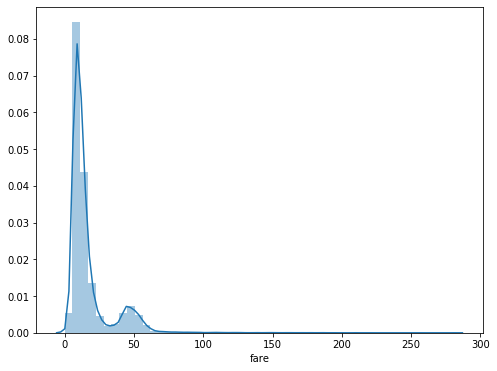

In [50]:
plt.figure(figsize=(8,6))
sns.distplot(trips['fare']);
# seems like most of the fares cluster around 0 to 30. and a handful of quite high ones

In [51]:
trips.sort_values(by='fare',ascending=False).head()

,start_time,end_time,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz,hour_start,weekday,SFO
9602,2012-09-03 20:55:00,2012-09-03 22:02:00,281.25,1.0,-122.387233,37.617143,-121.934592,38.272643,239.0,1252.0,20,0,1
23259,2012-09-07 22:34:00,2012-09-08 00:05:00,255.75,1.0,-122.384547,37.617148,-121.353468,37.982967,239.0,0.0,22,4,1
41438,2012-09-11 01:24:00,2012-09-11 02:16:00,219.35,1.0,-122.397640,37.793355,-121.889352,37.332805,1.0,558.0,1,1,0
13911,2012-09-06 18:37:00,2012-09-06 19:40:00,215.30,1.0,-122.390233,37.615377,-122.148178,38.052638,239.0,1211.0,18,3,1
9144,2012-09-03 17:40:00,2012-09-03 18:30:00,210.00,1.0,-122.390143,37.615127,-121.857482,37.301582,239.0,563.0,17,0,1


In [52]:
trips.sort_values(by='fare',ascending=True).head()

,start_time,end_time,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz,hour_start,weekday,SFO
35114,2012-09-10 22:27:00,2012-09-10 22:44:00,0.0,1.0,-122.515832,37.929987,-122.441647,37.793855,1441.0,49.0,22,0,0
31922,2012-09-11 21:31:00,2012-09-11 21:42:00,0.0,1.0,-122.440477,37.770990,-122.400258,37.794973,88.0,22.0,21,1,0
16062,2012-09-05 20:57:00,2012-09-05 21:38:00,0.0,1.0,-122.394605,37.777168,-122.165267,37.444040,109.0,356.0,20,2,0
12112,2012-09-04 07:08:00,2012-09-04 07:29:00,0.0,1.0,-122.411138,37.748365,-122.439378,37.761283,119.0,94.0,7,1,0
16466,2012-09-06 05:25:00,2012-09-06 05:30:00,0.0,1.0,-122.393393,37.775633,-122.402975,37.786653,109.0,12.0,5,3,0


Looks like we have some really high fares, taz 0, and 0 fares.

We will will only address for taz for brevity:
0 taz refers to out of bay area.

In [53]:
trips[trips['start_taz'] == 0].shape[0]

1018

In [54]:
trips[trips['end_taz'] == 0].shape[0]

1214

In [55]:
trips.shape[0]

41897

In [56]:
trips['Taz 0'] = (trips['start_taz'] == 0) | (trips['end_taz'] == 0)
trips['Taz 0'] = trips['Taz 0'].astype(int)
trips.head()

,start_time,end_time,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz,hour_start,weekday,SFO,Taz 0
0,2012-09-01 00:11:00,2012-09-01 00:20:00,13.20,1.0,-122.413540,37.802683,-122.421277,37.785395,38.0,30.0,0,5,0,0
1,2012-09-01 00:23:00,2012-09-01 00:31:00,10.65,1.0,-122.419700,37.786090,-122.435217,37.762177,30.0,94.0,0,5,0,0
2,2012-09-01 00:45:00,2012-09-01 00:49:00,9.00,1.0,-122.415120,37.774672,-122.407657,37.782615,10.0,11.0,0,5,0,0
3,2012-09-01 00:41:00,2012-09-01 00:54:00,13.95,2.0,-122.419392,37.806622,-122.415393,37.778115,40.0,10.0,0,5,0,0
4,2012-09-01 01:09:00,2012-09-01 01:13:00,7.35,1.0,-122.429722,37.797790,-122.418060,37.789032,45.0,32.0,1,5,0,0


**Discussion** 

What do you think we should do with fares that are 0?

In [57]:
sum(trips['fare'] == 0)

125

Lets drop some unncessary information now.

In [58]:
trips = trips.drop(['start_time','end_time','start_lng','start_lat','end_lng','end_lat'], axis=1)
trips.head()

,fare,number_pax,start_taz,end_taz,hour_start,weekday,SFO,Taz 0
0,13.20,1.0,38.0,30.0,0,5,0,0
1,10.65,1.0,30.0,94.0,0,5,0,0
2,9.00,1.0,10.0,11.0,0,5,0,0
3,13.95,2.0,40.0,10.0,0,5,0,0
4,7.35,1.0,45.0,32.0,1,5,0,0


**Discussion**

Given what we have, what else could we augment and add to our dataset?

# Part 2: Starting the ML Process

We will now go through the process for creating a model.

**We will:**
1. Create a baseline model 
1. Try a regression tree tuning one parameter
1. Tune multiple parameters
1. Try some different types of feature engineering

### Baseline Model: Linear Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [59]:
# classic test train split
from sklearn.model_selection import train_test_split

train = trips.loc[:, trips.columns != 'fare']
target = trips['fare']

# splitting into train and test 
X_train, X_test, Y_train, Y_test = train_test_split(train, target, test_size=.1, random_state=42)

# splitting train into train and val
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=.223, random_state=42)

print('Precentage of data')
print()
print('Train','             Val','                Test')
print(X_train.shape[0] / trips.shape[0],X_val.shape[0] / trips.shape[0],X_test.shape[0] / trips.shape[0]  )

Precentage of data

Train              Val                 Test
0.6992863450843736 0.20070649449841277 0.10000716041721364


In [60]:
from sklearn.linear_model import LinearRegression

# Creating Loss Function 
rmse = lambda x, y: np.sqrt(np.mean((x-y)**2))

# Instaniating our model 
baseline = LinearRegression()

# training it 
baseline.fit(X_train, Y_train)

# evaluating it
train_error = rmse(baseline.predict(X_train), Y_train)

val_error = rmse(baseline.predict(X_val), Y_val)
print('Baseline Train Error')
print(train_error)
print()
print('Baseline Validation Error')
print(val_error)

Baseline Train Error
8.850905829208362

Baseline Validation Error
9.098413484279162


**Discussion**

Why is training error less than validation error?

**Visualzing our model**

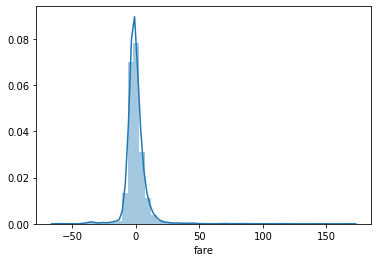

In [62]:
sns.distplot(Y_val - baseline.predict(X_val));

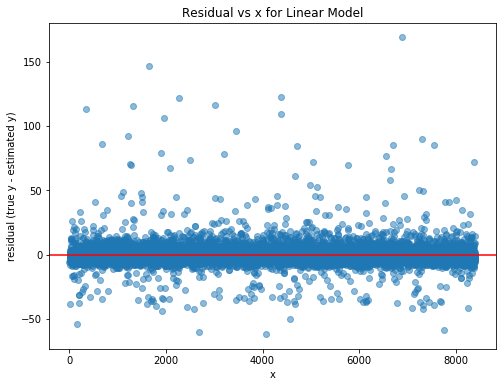

In [68]:
plt.figure(figsize=(8,6))      
plt.scatter(np.arange(len(X_val)), Y_val - baseline.predict(X_val),alpha=.5)
plt.xlabel('x')
plt.ylabel('residual (true y - estimated y)')
plt.title('Residual vs x for Linear Model')
plt.axhline(y = 0, color='r');

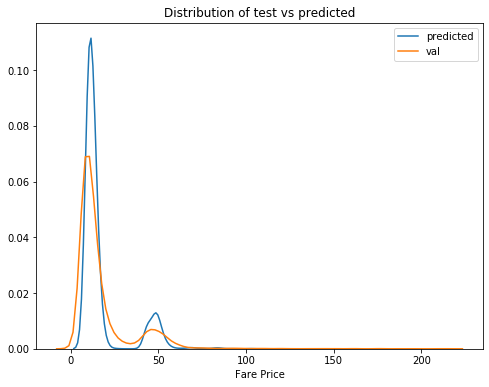

In [67]:
plt.figure(figsize=(8,6))
sns.distplot(baseline.predict(X_val), hist=False, label='predicted')
sns.distplot(Y_val, hist=False, label='val')
plt.title('Distribution of test vs predicted')
plt.xlabel('Fare Price');

### Hyper parameter tuning

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
# n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_features
# max_leaf_nodes, min_impurity_decrease, min_impurity_split

# set up sklearn's kfold object 
kf = KFold(n_splits=4)

# range of parameters to try
test_vals = [10,20,30,40,50]

val_errors = []

start = time.time()
for i in test_vals:
    # create new model for each testing value 
    model = RandomForestRegressor(n_estimators=i)
    
    # save errors here on each split
    validation_errors = []
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx] 
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        # Compute the RMSE on the validation split
        pred = model.predict(split_X_valid)
        error = rmse(split_Y_valid, pred)

        validation_errors.append(error)
    # for each outer loop iteration, append the mean validation error as that error
    val_errors.append(np.mean(validation_errors))
print(round(time.time() - start, 2), ' seconds')

31.09  seconds


In [72]:
for i in list(zip(test_vals, val_errors)):
    print(i)

(10, 5.959154809160998)
(20, 5.801626136279052)
(30, 5.723827695651759)
(40, 5.73454160572549)
(50, 5.6994992118278605)


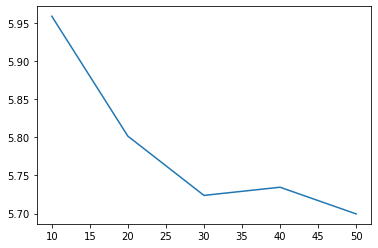

In [73]:
plt.plot(test_vals, val_errors);

In [75]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[10,50,100,150,300], 
          'max_features':['auto','sqrt','log2'],
          'max_depth': [5,15,30,45]}

grid = GridSearchCV(estimator=RandomForestRegressor(), 
                    param_grid=params, 
                    cv=2)

start = time.time()
grid.fit(X_train,Y_train)
print(f'{round(time.time() - start, 2)} seconds')

224.84 seconds


In [76]:
for param, score in zip(grid.cv_results_['params'], grid.cv_results_['mean_test_score']):
    print(param, score)

{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 10} 0.8231053795113527
{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 50} 0.8259928051375017
{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100} 0.8292746878175179
{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 150} 0.8280989413617216
{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 300} 0.8288476639120136
{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 10} 0.765634547166142
{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 50} 0.760512529802326
{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100} 0.7649434882109221
{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 150} 0.7683958546741885
{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300} 0.7695125180119768
{'max_depth': 5, 'max_features': 'log2', 'n_estimators': 10} 0.7670452793364794
{'max_depth': 5, 'max_features': 'log2', 'n_estimators': 50} 0.7698931612079596
{'max_depth': 5, 'max_features': 'lo

In [77]:
grid

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [5, 15, 30, 45],
 

In [78]:
# grid 
train_error = rmse(grid.predict(X_train), Y_train)

val_error = rmse(grid.predict(X_val), Y_val)
print('Random Forest Train Error')
print(train_error)
print()
print('Random Forest Validation Error')
print(val_error)

Random Forest Train Error
3.2352093035969816

Random Forest Validation Error
5.987008017803979


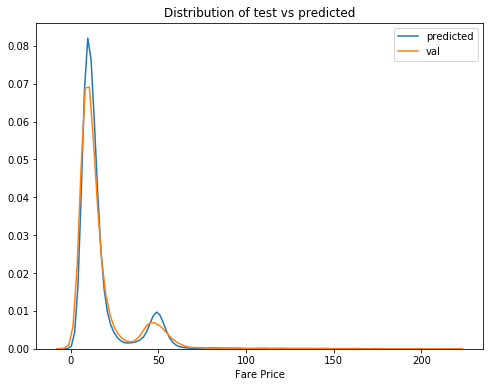

In [79]:
plt.figure(figsize=(8,6))
sns.distplot(grid.predict(X_val), hist=False, label='predicted')
sns.distplot(Y_val, hist=False, label='val')
plt.title('Distribution of test vs predicted')
plt.xlabel('Fare Price');

**Discussion** 

What do you observe about this model?

It looks like our model isn't giving enough weight to most common ones, its also not capturing the trend around 50 dollars

**Hypothesis**: The outliers in the model are pulling us away from the centers. Why might that be?

In [80]:
grid.best_params_

{'max_depth': 15, 'max_features': 'auto', 'n_estimators': 100}

In [82]:
# Lets try the new model with mae as the error to weight outliers less
start = time.time()
mae_forrest = RandomForestRegressor(n_estimators=100, max_depth=10, criterion='mae')
print('fitting')
mae_forrest.fit(X_train, Y_train)
print('Done fitting')
train_error = rmse(mae_forrest.predict(X_train), Y_train)

val_error = rmse(mae_forrest.predict(X_val), Y_val)
print('Random Forest MAE Train Error')
print(train_error)
print()
print('Random Forest MAE Validation Error')
print(val_error)
print(f"{round(time.time() - start, 2)} seconds")

'''
Baseline Train Error
3.920464004333598

Baseline Validation Error
5.768882270003845
'''

fitting
Done fitting
Random Forest MAE Train Error
4.761994447470884

Random Forest MAE Validation Error
5.919109619177678
1302.06 seconds


'\nBaseline Train Error\n3.920464004333598\n\nBaseline Validation Error\n5.768882270003845\nCell took 11.767005225022634 minutes\n'

Text(0.5, 0, 'Fare Price')

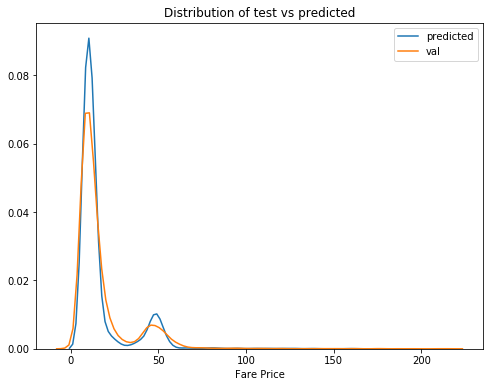

In [83]:
plt.figure(figsize=(8,6))
sns.distplot(mae_forrest.predict(X_val), hist=False, label='predicted')
sns.distplot(Y_val, hist=False, label='val')
plt.title('Distribution of test vs predicted')
plt.xlabel('Fare Price')

### Regularization

In [84]:
start = time.time()
# changing the depth in order to regularize
rmse_forest = RandomForestRegressor(n_estimators=100, max_depth=5)

rmse_forest.fit(X_train, Y_train)

train_error = rmse(rmse_forest.predict(X_train), Y_train)

val_error = rmse(rmse_forest.predict(X_val), Y_val)
print('Random Forest RMSE Train Error')
print(train_error)
print()
print('Random Forest RMSE Validation Error')
print(val_error)
print(f"{round(time.time() - start, 2)} seconds")

Random Forest RMSE Train Error
6.191759001467333

Random Forest RMSE Validation Error
6.50612542407612
1.49 seconds


Text(0.5, 0, 'Fare Price')

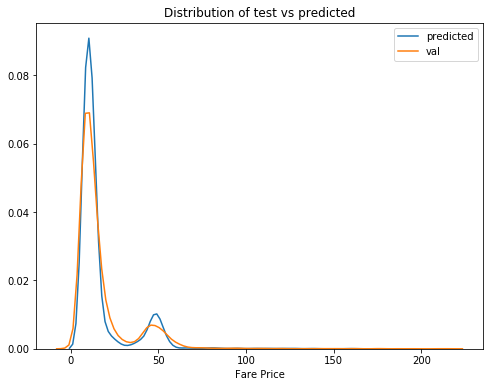

In [85]:
plt.figure(figsize=(8,6))
sns.distplot(mae_forrest.predict(X_val), hist=False, label='predicted')
sns.distplot(Y_val, hist=False, label='val')
plt.title('Distribution of test vs predicted')
plt.xlabel('Fare Price')

**Discussion**

What happened here? Why did validation error increase instead of decrease?

In [86]:
# example of a function to write once, then to run again when you need it.

def run_model(model, train, test, show_plot, show_res):
    ''' 
    Runs the sklearn's linear regression nd returns the rmse on training and test
    then plots the residuals. Also does Kfold cross validation 
    '''
    X_train, X_test, Y_train, Y_test = train_test_split(train, test, test_size=.1, random_state=np.random.seed(44))
    model.fit(X_train, Y_train)
    train_error = rmse(model.predict(X_train), Y_train)
    test_error = rmse(model.predict(X_test), Y_test)
    CV = compute_CV_error(model, train, test)
    print("Training RMSE:", train_error)
    print("CV RMSE:", CV)
    print("Test RMSE:", test_error)
    
   
    if show_res == True:
        y_pred = model.predict(X_train)
        plt.figure(figsize=(8,5))
        sns.distplot(Y_test, hist=False, label='test')
        sns.distplot(y_pred, hist=False, label='predicted')
        plt.title('Distribution of test vs predicted')
        plt.xlabel('Fare Price')
    if show_plot == True:
        plt.figure(figsize=(8,6))      
        plt.scatter(np.arange(len(X_test)), Y_test - model.predict(X_test), alpha=.5)
        plt.xlabel('x')
        plt.ylabel('residual (true y - estimated y)')
        plt.title('Residual vs x for Linear Model')
        plt.axhline(y = 0, color='r')

#         sns.kdeplot(np.arange(len(X_test)), Y_test - model.predict(X_test))
    return [train_error, CV, test_error]


def compute_CV_error(model, X_train, Y_train,k=4):
    '''
    Split the training data into subsets. Applies Kfold CV
    inputs:
        model: an sklearn model with fit and predict functions 
        X_train (data_frame): Training data
        Y_train (data_frame): Label 
    Return:
        the average validation MSE for the 4 splits.
    
    '''
    kf = KFold(n_splits=k)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx] 
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        fit = model.predict(split_X_valid)
        # Compute the RMSE on the validation split
        error = rmse(split_Y_valid, fit)

        validation_errors.append(error)
        
    return np.mean(validation_errors)

**Discuss**

If you were delegating tasks to your team, what would you tell them to try  to improve our model? 

## Final observations 

**Now we have many hypotheses of how to improve our model**

1. We have a lot of deeper features to find. We now what what we want to do. 
2. We also know that our model isn't capturing something of importance near the middle. Could either be model tuning or features fed in. 
3. We know that outliers are doing something odd to our model. 

Given that this is a buisnesss problem, one model won't fix this. This could be done in colloboration with some heuristics and human intervention. Should we have a whole seperate model to handle the outliers? Or should we let humans handle it. 

Better to create a model that says, given these parameters and setup, we do quite well. For these other cases, lets tackle it a different way.

____
<center>
    <b>Created by Alan Cha, with modifications by Yuyang Zhong</b><br>
This work licensed under Creative Commons BY-NC-SA 4.0
</center>
<img src="https://dss.berkeley.edu/static/img/logo.jpg" width="150">